[Chapter 5] Financial Labels

In [18]:
import numpy as np
import pandas as pd

import statsmodels.api as sml

import matplotlib.pyplot as plt

t-Value of a Linear Trend

In [7]:
def tValLinR(close):
    """
    tValue from a linear trend
    x_{t+l} = b0 + b1*l + e_{t+l}
    tstat_b1 = b1 / sigma(b1)
    l = 0, ..., L (L sets the look-forward period)  
    """
    # create an array filled with ones, having the same number of rows as close and 2 columns. 
    # This array will represent the independent variables for the linear regression.(the first column of ones respresent intercept) 
    x = np.ones((close.shape[0], 2))
    
    # generate a sequence of numbers representing the time index or independent variable for the linear trend. 
    # For each data point in close, there's a corresponding sequential number representing its position in the series.
    x[:, 1] = np.arange(close.shape[0])

    # estimate the relationship between a dependent variable (close) and independent variables (x) 
    # by minimizing the sum of the squared differences between the observed and predicted values
    ols = sml.OLS(close, x).fit()

    # return the t-value corresponding to the slope coefficient
    return ols.tvalues[1]

trend scanning method

In [ ]:
def getBinsFromTrend(molecule, close, span):
    """
    pick the time horizon that yields the maximum absolute t-value (strongest evidence of a trend).
    label the original time point by the sign (+/-) of that trend.
    
    arguments:
    - molecule: the index of observations we wish to label
    - close: time series of {x_t}
    - span: the set of values of L that the algo will evaluate in search for the max absolute t-value
    
    ouputs:
    - t1: end time for the identified trend
    - tVal: t-value associated with the estimated trend coefficient
    - bin: sign of the trend
    """
    out = pd.DataFrame(index=molecule, columns=['t1', 'tVal','bin'])

    #  creates a sequence of integers corresponding to different forecast horizons (lengths of windows) to try
    #  e.g. if span = (2, 10), hrzns will be 2, 3, 4, ..., 9
    hrzns = range(*span)
    
    for dt0 in molecule:
        df0 = pd.Series()
        
        # find the integer position (location) of dt0 in the close time series index
        iloc0 = close.index.get_loc(dt0)

        # if pos(dt0) + max horizon window goes beyond the end of the available time series
        # skip this dt0 because you can't get enough future data.
        if iloc0+max(hrzns) > close.shape[0]: continue

        for hrzn in hrzns: # loop over all forecast horizons (defined in span)
            dt1 = close.index[iloc0+hrzn-1]
            df1 = close.loc[dt0:dt1]
            df0.loc[dt1] = tValLinR(df1.values)
        dt1 = df0.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
        out.loc[dt0, ['t1','tVal','bin']] = df0.index[-1], df0[dt1], np.sign(df0[dt1]) # prevent leakage (use info only up to t1)
    out['t1'] = pd.to_datetime(out['t1'])
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')
    return out.dropna(subset=['bin'])

experimental results

C:\Users\user\AppData\Local\Temp\ipykernel_18792\336965772.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
C:\Users\user\AppData\Local\Temp\ipykernel_18792\336965772.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
C:\Users\user\AppData\Local\Temp\ipykernel_18792\336965772.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
C:\Users\user\AppData\Local\Temp\ipykernel_18792\336965772.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
C:\Users\use

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]


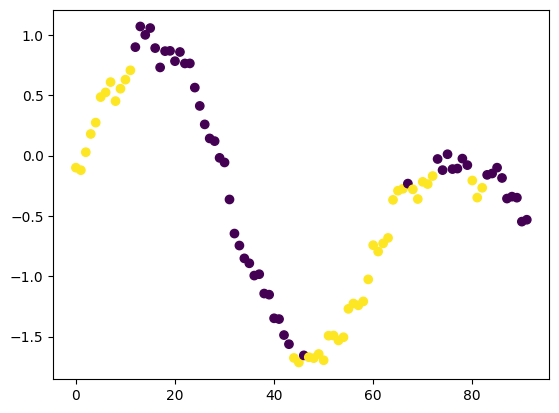

In [24]:
df0 = pd.Series(np.random.normal(0, .1, 100)).cumsum()
df0 += np.sin(np.linspace(0, 10, df0.shape[0]))
df1 = getBinsFromTrend(df0.index, df0, [3, 10, 1])
plt.scatter(df1.index, df0.loc[df1.index].values, 
    c=df1['bin'].values, cmap='viridis')
plt.savefig('fig5.1.png')
plt.clf()
plt.close()
plt.scatter(df1.index, df0.loc[df1.index].values, c=df1['bin'].values, cmap='viridis')
print(df1['bin'].values)
# plot a gaussian random walk with trend, where the colors differentiate four clearly distinct trends
# 1 in yellow and -1 in violet. te binarly labels appropriate for classification problem, omit information about the strength of the trend.